In [1]:
x = [[5, 7, 8], [6, 3], [3], [1]]
import helpers
xt, xlen = helpers.batch(x)
x

[[5, 7, 8], [6, 3], [3], [1]]

In [2]:
xt

array([[5, 6, 3, 1],
       [7, 3, 0, 0],
       [8, 0, 0, 0]], dtype=int32)

In [3]:
xlen

[3, 2, 1, 1]

In [4]:
import numpy as np
import tensorflow as tf
import helpers

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [5]:
tf.__version__

'1.0.0'

In [6]:
PAD = 0
EOS = 1

vocab_size = 10
input_embedding_size = 20

encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units

In [7]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [8]:
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [9]:
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

In [10]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, decoder_inputs)

In [11]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
    encoder_cell, encoder_inputs_embedded,
    dtype=tf.float32, time_major=True,
)

del encoder_outputs

In [12]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [14]:
#A fully connected layer between encoder_final_state.c (encoder_hidden_units) and decoder_hidden_units
def multilayer_perceptron(x, w, b):
    layer_1 = tf.add(tf.matmul(x, w), b)
    return tf.nn.relu(layer_1)
    
with tf.variable_scope('c'):
    wc = tf.Variable(tf.random_normal([encoder_hidden_units, decoder_hidden_units]))
    bc = tf.Variable(tf.random_normal([decoder_hidden_units]))
    
with tf.variable_scope('h'):
    wh = tf.Variable(tf.random_normal([encoder_hidden_units, decoder_hidden_units]))
    bh = tf.Variable(tf.random_normal([decoder_hidden_units]))
projected_state = tf.contrib.rnn.LSTMStateTuple(
    c=multilayer_perceptron(encoder_final_state.c, wc, bc),
    h=multilayer_perceptron(encoder_final_state.h, wh, bh),
)

In [15]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
    decoder_cell, decoder_inputs_embedded,

    initial_state=projected_state,

    dtype=tf.float32, time_major=True, scope="plain_decoder",
)

In [16]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, vocab_size)

decoder_prediction = tf.argmax(decoder_logits, 2)

In [17]:
decoder_logits

<tf.Tensor 'fully_connected/Reshape_1:0' shape=(?, ?, 10) dtype=float32>

In [18]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)

In [19]:
sess.run(tf.global_variables_initializer())

In [20]:
batch_ = [[6], [3, 4], [9, 8, 7]]

batch_, batch_length_ = helpers.batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_, dlen_ = helpers.batch(np.ones(shape=(3, 1), dtype=np.int32),
                            max_sequence_length=4)
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[6 3 9]
 [0 4 8]
 [0 0 7]]
decoder inputs:
[[1 1 1]
 [0 0 0]
 [0 0 0]
 [0 0 0]]
decoder predictions:
[[7 7 7]
 [7 7 7]
 [7 0 7]
 [0 0 0]]


In [21]:
batch_size = 100

batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[3, 4, 4]
[8, 6, 6, 7, 7]
[8, 9, 3, 5, 5, 3, 8]
[4, 9, 8, 3, 5, 6, 3, 9]
[4, 5, 5, 9, 3]
[2, 7, 9, 4, 3, 4, 4, 8]
[6, 6, 4, 5, 8, 3, 7, 7]
[3, 3, 7, 9, 5]
[8, 2, 9]
[8, 2, 7, 3]


In [22]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, _ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] for sequence in batch]
    )
    decoder_inputs_, _ = helpers.batch(
        [[EOS] + (sequence) for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        decoder_inputs: decoder_inputs_,
        decoder_targets: decoder_targets_,
    }

In [24]:
loss_track = []
max_batches = 3001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()
except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.240952968597412
  sample 1:
    input     > [3 5 6 3 5 6 5 0]
    predicted > [7 7 7 6 6 6 6 6 6]
  sample 2:
    input     > [2 4 2 8 2 2 2 0]
    predicted > [7 0 7 0 0 0 0 0 0]
  sample 3:
    input     > [6 8 3 0 0 0 0 0]
    predicted > [7 7 7 6 0 0 0 0 0]

batch 1000
  minibatch loss: 0.3208310902118683
  sample 1:
    input     > [3 6 4 5 6 0 0 0]
    predicted > [3 6 4 5 6 1 0 0 0]
  sample 2:
    input     > [5 3 7 0 0 0 0 0]
    predicted > [5 3 7 1 0 0 0 0 0]
  sample 3:
    input     > [7 4 2 8 8 3 7 4]
    predicted > [7 8 8 8 8 3 7 4 1]

batch 2000
  minibatch loss: 0.19016094505786896
  sample 1:
    input     > [6 4 3 5 0 0 0 0]
    predicted > [6 4 3 5 1 0 0 0 0]
  sample 2:
    input     > [5 6 8 5 2 2 3 3]
    predicted > [5 6 8 5 2 2 3 3 1]
  sample 3:
    input     > [5 2 2 6 7 3 0 0]
    predicted > [5 2 2 6 7 3 1 0 0]

batch 3000
  minibatch loss: 0.15100884437561035
  sample 1:
    input     > [6 3 7 9 0 0 0 0]
    predicted > [6 3 7 

loss 0.1559 after 300100 examples (batch_size=100)


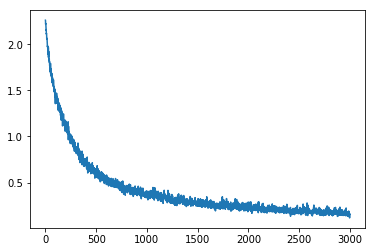

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))